# **Clustering des titres**

Le but de ce notebook est d'essayer de faire un clustering sur la colonne titres de notre fichier, a fin de pouvoir ensuite donner un thème par cluster 

In [1]:
# Importation des bibliothèques nécessaires
# pandas pour la manipulation des données 
# scikit-learn pour la création de la matrice tf-idf et le calcul de la similarité cosinus
# Dbscan pour le clustering
# nltk pour les stop words en français

import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
import numpy as np
from nltk.corpus import stopwords
import nltk

# Télécharger les stop words français si nécessaire
nltk.download('stopwords', quiet=True)
french_stop_words = stopwords.words('french')

In [2]:
# Chargement des données 
data= pd.read_csv("articles.csv")
# Nombre d'articles 
print (data.shape[0])
print (data.columns)
# Remplacer le nom de la première colonne par "id"
data.rename(columns={data.columns[0]: "id"}, inplace=True)
print (data.columns)

1269
Index(['Unnamed: 0', 'title', 'year', 'language', 'Nb_authors'], dtype='object')
Index(['id', 'title', 'year', 'language', 'Nb_authors'], dtype='object')


In [3]:
# Dans le fichier y'a des articles en français et en anglais 
data_fr = data[data['language'] == 'fr']
print (data_fr.shape[0])
data_en = data[data['language'] == 'en']
print (data_en.shape[0])

1133
120


In [4]:
# Récupération du vocabulaire français à partir des titres des articles

import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as french_stop_words

# Charger le modèle français
nlp = spacy.load("fr_core_news_sm")

# Initialiser un set vide pour le vocabulaire
vocab_fr = set()

for title in data_fr['title']:
    doc = nlp(title)
    for token in doc:
        # garder seulement les mots alphabétiques, minuscules, non stopwords
        lemma = token.lemma_.lower()
        if token.is_alpha and lemma not in french_stop_words:
            vocab_fr.add(lemma)

print("Nombre de mots uniques :", len(vocab_fr))


Nombre de mots uniques : 1914


In [5]:
print(vocab_fr)

{'dépendance', 'catégorisation', 'champ', 'information', 'multidimensionnels', 'analyse', 'instance', 'argumentation', 'quantitatif', 'synchronique', 'signature', 'suspects', 'appui', 'policier', 'décisionnel', 'complémentarité', 'multicouche', 'cnd', 'préparation', 'poisson', 'abstop', 'coût', 'fed', 'émotion', 'différence', 'ppmi', 'automate', 'divergente', 'proximal', 'simulation', 'apprentissage', 'forum', 'entropie', 'automatiquement', 'crédibilist', 'pharmacovigilance', 'question', 'roc', 'précision', 'subjectivité', 'tmd', 'succès', 'algébrique', 'musique', 'reconnaissance', 'journalistique', 'condenser', 'territorial', 'index', 'combiner', 'crowdsourcing', 'transmute', 'alignement', 'naturel', 'levé', 'triangulation', 'ontobiotope', 'archiview', 'partitionnement', 'réaliste', 'plasmodium', 'reuters', 'ppc', 'desesper', 'paramétrage', 'immunitaire', 'morphosyntaxique', 'particulier', 'conduite', 'typer', 'théorique', 'graphe', 'normalité', 'boosting', 'dépendant', 'kohonen', 'pr

In [6]:
# Nettoyage manuel des mots non pertinents
manual_stop_words = {
    # Bruit & Lettres isolées
    'p', 'n', 'b', 'c', 'j', 'v', 'm', 'r', 'k', 'cl', 'sou', 'tr', 'vs', 'via', 'multi', 'intro', 'chapitre',
    
    # Termes génériques de recherche
    'approche', 'approches', 'méthode', 'méthodes', 'système', 'systèmes',
    'application', 'applications', 'analyse', 'analyses', 'étude', 'études',
    'modèle', 'modèles', 'modélisation', 'algorithme', 'algorithmes',
    'problème', 'problèmes', 'solution', 'solutions', 'résultat', 'résultats',
    'outil', 'outils', 'processus', 'technique', 'techniques', 'concept',
    'contexte', 'cadre', 'travail', 'travaux',
    'contribution', 'contributions', 'cas', 'exemple', 'exemples', 'usage',
    'utilisation', 'proposition', 'démarche', 'principe', 'théorie', 'théorique',
    'pratique', 'état', 'art', 'vue', 'niveau', 'type', 'moyen', 'question',
    'enjeu', 'domaine', 'sujet', 
    
    # Verbes courants (formes lemmatisées probables)
    'utiliser', 'permettre', 'baser', 'proposer', 'présenter','définir', 'construire', 'générer', 'traiter',
    'extraire', 'apprendre',  'considérer', 'mesurer', 'voir',
    'faire', 'obtenir','viser', 'fournir', 'intégrer',
    'mettre', 'partir',  'montrer', 'conclure',
    
    # Adjectifs / Adverbes vagues
    'nouveau', 'nouvelle', 'nouveaux', 'nouvelles', 'bon', 'meilleur',
    'grand', 'petit', 'simple',
    'général', 'efficace', 'performant', 'rapide',  'classique', 'possible',
    'nécessaire', 'principal', 'important', 'haut', 'faible', 'large',
    'court', 'long', 'très', 'trop', 'peu', 'bien', 'mieux'
}
vocab_fr = vocab_fr - manual_stop_words
print(len(vocab_fr))

1827


In [7]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as english_stop_words

nlp_en = spacy.load("en_core_web_sm")


# Initialiser un set pour le vocabulaire anglais
vocab_en = set()

for title in data_en['title']:
    doc = nlp_en(title)
    for token in doc:
        lemma = token.lemma_.lower()
        # garder seulement les mots alphabétiques, minuscules, non stopwords
        if token.is_alpha and lemma not in english_stop_words:
            vocab_en.add(lemma)

print("Nombre de mots uniques en anglais :", len(vocab_en))


Nombre de mots uniques en anglais : 473


## **Articles en Français**

In [8]:
# Créons une colonne titre_clean en les mettant en miniscule sans stop word et en lemme 
def clean_title_fr(text):
    doc = nlp(text)
    return " ".join([token.lemma_.lower() 
                     for token in doc 
                     if token.is_alpha and token.lemma_.lower() not in french_stop_words])

# Appliquer sur la colonne 'title'
data_fr['title_clean'] = data_fr['title'].apply(clean_title_fr)

C:\Users\HP\AppData\Local\Temp\ipykernel_4396\4166352686.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fr['title_clean'] = data_fr['title'].apply(clean_title_fr)


In [9]:
# Construction de la matrice TF-IDF pour les articles en français en utilisant seulement les titres
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_fr = TfidfVectorizer(
    vocabulary=vocab_fr,  # on utilise le vocabulaire extrait précédemment
    max_df=0.8,                 # optionnel, mais sécuritaire
    min_df=2,                   # optionnel, mais sécuritaire
    ngram_range=(1, 2)          # unigrams et bigrams
)

# Construction de la matrice TF-IDF
tfidf_matrix_fr = vectorizer_fr.fit_transform(data_fr['title_clean'])
print("TF-IDF matrix shape (fr):", tfidf_matrix_fr.shape)


TF-IDF matrix shape (fr): (1133, 1827)


In [10]:
"""
# Commençons avec les articles en français
# On utilise en premier le k-means 
# On essaye de determiner le meilleur K 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 14)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix_fr)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title("Méthode du coude")
plt.show() """

'\n# Commençons avec les articles en français\n# On utilise en premier le k-means \n# On essaye de determiner le meilleur K \nfrom sklearn.cluster import KMeans\nimport matplotlib.pyplot as plt\n\ninertia = []\nK = range(2, 14)\n\nfor k in K:\n    kmeans = KMeans(n_clusters=k, random_state=42)\n    kmeans.fit(tfidf_matrix_fr)\n    inertia.append(kmeans.inertia_)\n\nplt.plot(K, inertia, marker=\'o\')\nplt.xlabel("Nombre de clusters")\nplt.ylabel("Inertie")\nplt.title("Méthode du coude")\nplt.show() '

In [11]:
# Application du K-means 
# En regardant les résultats du challenge publiés, on constate que le nombre de clusters utilisé est 10
from sklearn.cluster import KMeans
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
data_fr["cluster"] = kmeans.fit_predict(tfidf_matrix_fr)

C:\Users\HP\AppData\Local\Temp\ipykernel_4396\462268148.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fr["cluster"] = kmeans.fit_predict(tfidf_matrix_fr)


In [12]:
terms = vectorizer_fr.get_feature_names_out()

In [ ]:
# Chaque cluster a un centroïde (un vecteur) qui est la moyenne des vecteurs TF-IDF de tous les documents dans ce cluster.
# Chaque dimension du vecteur correspond à un mot de ton vocabulaire.
# Plus la valeur dans le centroïde pour un mot est grande, plus ce mot est représentatif des documents du cluster.
# Le code prend les n mots avec les plus grandes valeurs dans le centroïde → ce sont ceux qui définissent le cluster.
# Du coup le premier mot est le plus proche du thème du cluster
import numpy as np

def get_top_words_per_cluster(model, terms, n_words=10):
    for i, centroid in enumerate(model.cluster_centers_):
        top_indices = centroid.argsort()[-n_words:][::-1]
        top_terms = [terms[ind] for ind in top_indices]
        print(f"Cluster {i} : {', '.join(top_terms)}")
get_top_words_per_cluster(kmeans, terms)

Cluster 0 : ontologie, alignement, sémantique, construction, texte, base, annotation, guider, entrer, owl
Cluster 1 : motif, séquentiel, extraction, fréquent, découverte, donnée, contrainte, base, trace, contextuel
Cluster 2 : aide, multidimensionnel, décision, donnée, fusion, navigation, xml, logiciel, acquisition, information
Cluster 3 : donnée, fouille, flux, classification, base, entrepôt, relationnel, symbolique, apprentissage, textuel
Cluster 4 : apprentissage, classification, réseau, connaissance, détection, sémantique, superviser, graphe, social, variable
Cluster 5 : temporel, séquence, série, spatio, événement, motif, dynamique, extraction, classification, apprentissage
Cluster 6 : règle, association, extraction, génération, classification, comparaison, exception, découverte, entrer, fouille
Cluster 7 : visualisation, intégration, interactif, donnée, classification, connaissance, exploration, parcours, fouille, utilisateur
Cluster 8 : recherche, image, information, classificat

In [14]:
for i in range(k):
    print(f"\n### Cluster {i}")
    print(data_fr[data_fr["cluster"] == i]["title"].head(3).values)


### Cluster 0
["Contraintes prescriptives compatibles avec OWL2-ER pour évaluer la complétude d'ontologies"
 "L'ontologie OntoBiotope pour l'étude de la biodiversité microbienne"
 "Vers une instance française de NELL : chaîne TLN multilingue et modélisation d'ontologie"]

### Cluster 1
["Découverte de motifs graduels partiellement ordonnés : application aux données d'expériences scientifiques"
 'Echantillonnage de motifs séquentiels sous contrainte sur la norme'
 'Fouille de Motifs Graduels Fermés Fréquents Sous Contrainte de la Temporalité']

### Cluster 2
["Une méthode pour l'estimation désagrégée de données de population à l'aide de données ouvertes"
 "Anonymiser des données multidimensionnelles à l'aide du coclustering"
 "Classification parcimonieuse pour l'aide à la reconnaissance de cibles radar"]

### Cluster 3
['Apport de la fouille de données pour la prévention du risque suicidaire'
 'Classification de Données Complexes par Globalisation de Mesures de Similarité via les Moyen

In [17]:
# Affichons le nombre d'articles par cluster
print(data_fr['cluster'].value_counts())

cluster
4    458
3    173
9    128
7     67
8     59
6     57
0     53
5     51
1     45
2     42
Name: count, dtype: int64


In [15]:
# On sauvgrade les résultats pour ensuite pouvoir définir un thème pour chaque cluster
data_fr.to_csv("clustered_articles_fr.csv", index=False)

En donnant la liste des mots représentatifs de chaque cluster a Chatgpt, on a eu les résultats suivant 
| Cluster | Mots les plus représentatifs                                   | Thème proposé                                                   |
| ------- | -------------------------------------------------------------- | --------------------------------------------------------------- |
| 0       | ontologie, alignement, sémantique, construction, texte         | **Ontologies et traitement sémantique du texte**                |
| 1       | motif, séquentiel, extraction, fréquent, découverte            | **Analyse de motifs et séquences dans les données**             |
| 2       | aide, multidimensionnel, décision, donnée, fusion              | **Aide à la décision et analyse multidimensionnelle**           |
| 3       | donnée, fouille, flux, classification, base                    | **Data mining et gestion de flux de données**                   |
| 4       | apprentissage, classification, réseau, connaissance, détection | **Apprentissage automatique et réseaux de connaissances**       |
| 5       | temporel, séquence, série, spatio, événement                   | **Analyse de séries temporelles et données spatio-temporelles** |
| 6       | règle, association, extraction, génération, classification     | **Règles d’association et génération de connaissances**         |
| 7       | visualisation, intégration, interactif, donnée, classification | **Visualisation et exploration interactive de données**         |
| 8       | recherche, image, information, classification, échelle         | **Recherche d’information et traitement d’images**              |
| 9       | extraction, document, web, connaissance, sémantique            | **Extraction d’information et analyse documentaire web**        |


In [16]:
# On rajoute maintenant une colonne thème ou on correspond le thème à chaque cluster
cluster_themes = {
    0: "Ontologies et traitement sémantique du texte",
    1: "Analyse de motifs et séquences dans les données",
    2: "Aide à la décision et analyse multidimensionnelle",
    3: "Data mining et gestion de flux de données",
    4: "Apprentissage automatique et réseaux de connaissances",
    5: "Analyse de séries temporelles et données spatio-temporelles",
    6: "Règles d’association et génération de connaissances",
    7: "Visualisation et exploration interactive de données",
    8: "Recherche d’information et traitement d’images",
    9: "Extraction d’information et analyse documentaire web"
}
data_fr["theme"] = data_fr["cluster"].map(cluster_themes)
# On sauvgarde dans le meme fichier clustered_articles_fr.csv
data_fr.to_csv("clustered_articles_fr.csv", index=False)

C:\Users\HP\AppData\Local\Temp\ipykernel_4396\3465664167.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fr["theme"] = data_fr["cluster"].map(cluster_themes)


### **Evolution des thèmes dans le temps**

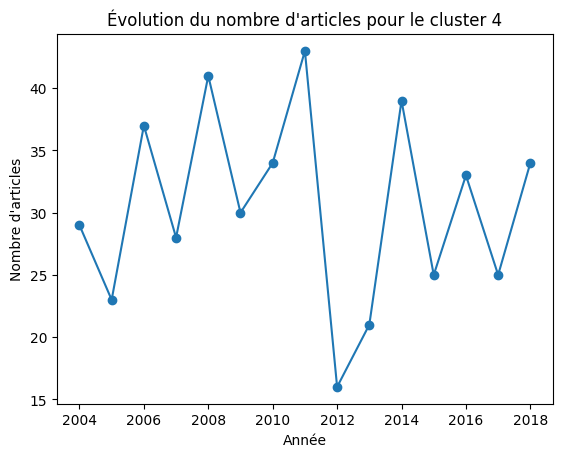

In [ ]:
# Maintenant l'idée est de regarder l'évolution de nombre d'articles par thème dans le temps 
# Commençons avec un courbe pour le cluster 4, ou y a le plus grand nombre d'articles 
# On utilise la colonne year pour l'année
import matplotlib.pyplot as plt
cluster_id = 4
cluster_data = data_fr[data_fr['cluster'] == cluster_id]
articles_per_year = cluster_data['year'].value_counts().sort_index()
plt.plot(articles_per_year.index, articles_per_year.values, marker='o')
plt.xlabel("Année")
plt.ylabel("Nombre d'articles")
plt.title(f"Évolution du nombre d'articles pour le cluster {cluster_id}")
plt.show()

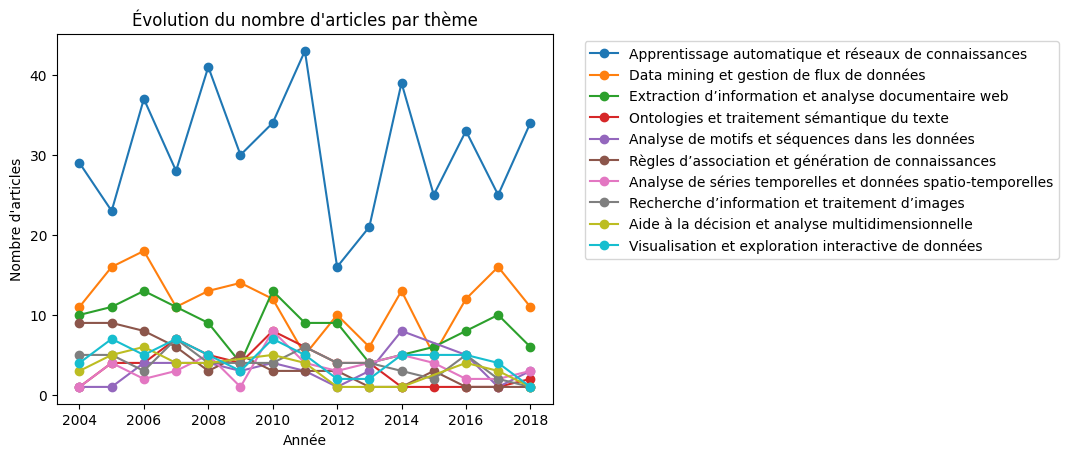

In [ ]:
# Maintenant on va faire un graphique sur le nombre d'articles par thème pour toutes les années
themes = data_fr['theme'].unique()
for theme in themes:
    theme_data = data_fr[data_fr['theme'] == theme]
    articles_per_year = theme_data['year'].value_counts().sort_index()
    plt.plot(articles_per_year.index, articles_per_year.values, marker='o', label=theme)
plt.xlabel("Année")
plt.ylabel("Nombre d'articles")
plt.title("Évolution du nombre d'articles par thème")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


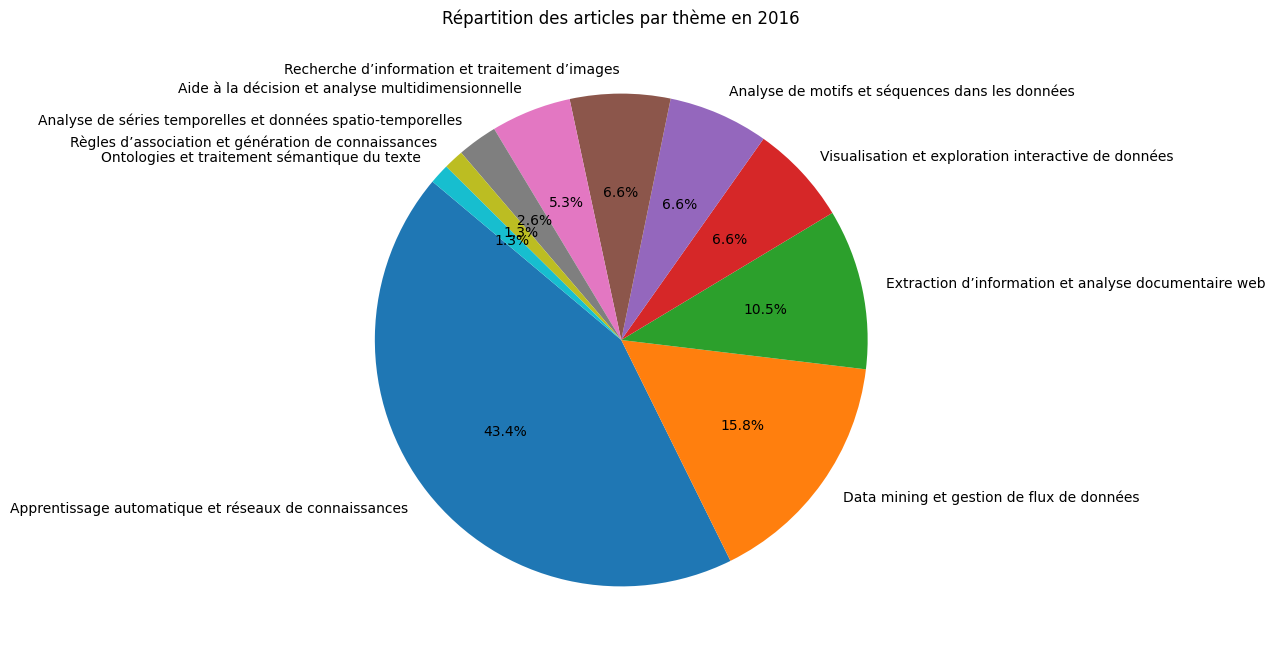

In [21]:
# Prenons l'année 2016 et regardons le nombre d'articles par thème, sous forme de pie chart
data_2016 = data_fr[data_fr['year'] == 2016]
articles_per_theme_2016 = data_2016['theme'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(articles_per_theme_2016.values, labels=articles_per_theme_2016.index, autopct='%1.1f%%', startangle=140)
plt.title("Répartition des articles par thème en 2016")
plt.show()


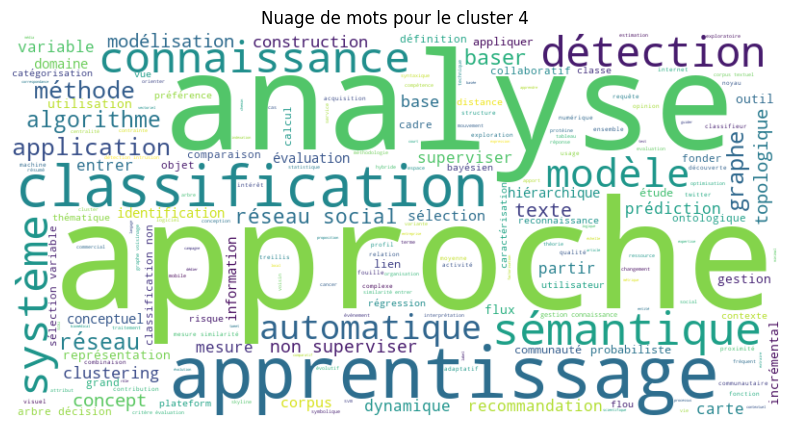

In [22]:
# Faisons un nuage de mots pour chaque cluster 
# Prenons le cluster 4 par exemple
from wordcloud import WordCloud
cluster_id = 4
cluster_data = data_fr[data_fr['cluster'] == cluster_id]
text = " ".join(cluster_data['title_clean'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Nuage de mots pour le cluster {cluster_id}")
plt.show()